# A Tale of Two Cities 

__author__ = "Rahul Kakodkar"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Rahul Kakodkar", "Efstratios N. Pistikopoulos"]
__license__ = "MIT"
__version__ = "1.0.5"
__maintainer__ = "Rahul Kakodkar"
__email__ = "cacodcar@tamu.edu"
__status__ = "Production"


The following case study considers two locations Houston and Athens. 

The basic premise is to meet a demand for hydrogen in Athens through production in Houston. 


The following processes are considered in Houston - 

- Modular nuclear reactors (ASMR)
- Proton Exchange Membrane Electrolyzers (PEM)
- Natural Gas Combined Cycle with 95% carbon capture (NGCC)
- Lithium-ion batteries (LiI/LiI_discharge)
- Solar Photovoltaics (PV) 
- Wind Farms (WF)
- SMR + Carbon Capture Utilization and Storage (SMRH)
- Offshore Aquifers (AQoff)
- Hydrogen Compression and Decompression 

For shipment, we conside a Ship to transport the hydrogen from Houston to Athens. 

## Import Modules

In [1]:
import sys
sys.path.append('src')

In [2]:

from energiapy.solution.result import Result
from energiapy.solution.solve import solve
import pandas
from itertools import product
from matplotlib import rc
import matplotlib.pyplot as plt
from energiapy.plot.plot_results import CostY, CostX
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.model.bounds import CapacityBounds
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results, calculate_hourly
from energiapy.components import *
import numpy
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.aggregation.reduce_scenario import reduce_scenario, Clustermethod
from energiapy.aggregation.ahc import agg_hierarchial_elbow, IncludeAHC, Fit


## Data Import

The following data is needed for the model

- solar and wind profiles : energiapy.fetch_nsrdb_data imports data from the NREL NSRDB database
- power demand : ERCOT for Houston
- Natural Gas prices: Henry Hub 


In [3]:
horizon = 1

### Weather data

Solar and wind data is obtained from the NSRDB hosted by NREL

In [4]:
coord_houston = (29.56999969482422, -95.05999755859375)
weather_houston = pandas.read_csv('data/weather_houston.csv', index_col=0)
weather_houston.index = pandas.to_datetime(weather_houston.index, utc = True)


C:\Users\cacodcar\AppData\Local\Temp\ipykernel_19636\20141400.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_houston.index = pandas.to_datetime(weather_houston.index, utc = True)


Solar irradiance (GNI, DNI, GHI) and weather conditions (cloud cover, etc.) are used to determine solar power generation potential

In [5]:
solar_houston_mean = weather_houston[['dni']][:8760]

In [6]:
wind_houston_mean = weather_houston[['wind_speed']][:8760]

In [7]:
solar_houston = solar_power_output(data= weather_houston, coord=coord_houston, sam = 'cecmod', module_params= 'Canadian_Solar_Inc__CS5P_220M', 
                                   inverter = 'cecinverter', inverter_params= 'ABB__MICRO_0_25_I_OUTD_US_208__208V_', 
                                   temperature_params= 'open_rack_glass_glass', aoi_model= 'no_loss', ac_model= 'sandia', spectral_model= 'no_loss')

Wind speeds are used to determine the wind power generation potential

In [8]:
wind_houston = wind_power_output(data= weather_houston, roughness_length= 0.1, turbine_type= 'V100/1800', hub_height= 92, 
                                 wind_speed_model= 'logarithmic', density_model = 'ideal_gas', temperature_model = 'linear_gradient', 
                                 power_output_model = 'power_coefficient_curve', density_correction = True, obstacle_height = 0, 
                                 observation_height = 10)

Hourly data is averaged over the years 2016 to 2020

In [9]:
# solar_houston_mean = calculate_hourly(data = solar_houston, what = 'mean', column_name= 'Value')
# wind_houston_mean = calculate_hourly(data = wind_houston, what = 'mean', column_name= 'Value')

solar_houston_mean = solar_houston
wind_houston_mean = wind_houston

### Natural gas prices

Natural gas prices are from the Henry price index at a daily temporal resolution.

The energia.make_henry_price_df function implicitly fills in gaps in data such as weekends and public holidays by repeating the last recorded prices For e.g. if the 4th of July will use the price for the 3rd of July a typical saturday and sunday will take the values for the last friday.

The stretch functionality stretches the values over the hourly temporal scale (8760) from a daily temporal scale (365), again through repetition.

Moreover, we can remove outliers usig the remove_outliers features in data_utils

In [10]:
ng_price_df = pandas.concat(
    [make_henry_price_df(file_name='data/Henry_Hub_Natural_Gas_Spot_Price_Daily.csv', year=2016 +i) for i in range(5)]) #, stretch = True

In [11]:
ercot = pandas.read_csv('ercot.csv', index_col=0)
ercot.index = pandas.to_datetime(ercot.index, utc = True)
ercot.loc['2016-11-06 23:00:00'] = ercot.loc['2016-11-06 22:00:00'] #random missing value

C:\Users\cacodcar\AppData\Local\Temp\ipykernel_19636\2618497395.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ercot.index = pandas.to_datetime(ercot.index, utc = True)


## Declare Problem 

In [12]:
scales = TemporalScale([horizon, 365, 24], design_scale = 0, scheduling_scale = 2)

## Define temporal scale


The variabilities of energy systems are best captured over a discretized spatio-temporal scale. In energiapy, the first declaration is the temporal scale. 

For e.g.: Here we declare three temporal scales at different levels from right to left. The interpretation of these scales is merely symentic. Scales can be declared as the problem demands.
- 0, annual, with 1 discretization
- 1, daily with 365 discretization
- 2, hourly with 24 discretization

In essence, we are creating a temporal scale of 8760 points.

**Big and small M**

In [13]:
bigM = 10**6
smallM = 0 # if adding minimum capacity for infrastructure add Constrainsts.NETWORK in constraints list

## Declare resources

Resources can be consumed, produced, stored, discharged (or sold). Resources measured as mass (sparing Uranium) are quantified on a per metric ton basis, energy feedstock and resources us a Mega Watt (MW) basis.

- Power and Hydrogen (H2) have varying demands which are captured using deterministic data inputs
- Methane (CH4) has varying purchase price

In [14]:

Solar = Resource(name = 'Solar', cons_max=1000, basis='MW', label='Solar Power')
Wind = Resource(name = 'Wind', cons_max=1000, basis='MW', label='Wind Power')
Power = Resource(name = 'Power',basis='MW', label='Power generated')
Uranium = Resource(name = 'Ur', cons_max=1000,
                   purchase_price=42.70/(250/2), basis='kg', label='Uranium')
H2 = Resource(name = 'H2',basis='tons', label='Hydrogen', discharge= True)
H2_C = Resource(name = 'H2(C)',basis='tons', label='Hydrogen(C)')
H2_sell = Resource(name = 'H2(S)',basis='tons', label='Hydrogen(Sell)', sell_price = 0.07)
CO2_AQoff = Resource(name = 'CO2(Aq)',basis='tons',
                     label='Carbon dioxide - sequestered')
H2O = Resource(name = 'H2O',cons_max=1000, purchase_price=0.001, basis='tons', label='Water', block='Resource')
CH4 = Resource(name = 'CH4', cons_max=1000, purchase_price = 0.03*1000, basis='tons',
               label='Natural gas') #price=max(ng_price_df['CH4'])
CO2 = Resource(name = 'CO2', basis='tons',
               label='Carbon dioxide', block='Resource')
CO2_Vent = Resource(name = 'CO2(V)',discharge=True, basis='tons',
                    label='Carbon dioxide - Vented')
O2 = Resource(name = 'O2', discharge=True, basis='tons', label='Oxygen')

c:\Users\cacodcar\energiapy\src\energiapy\components\resource.py:127: UserWarning: H2(S): discharge set to True, since sell_price is given
  warn(f'{self.name}: discharge set to True, since sell_price is given')


In [15]:
Water = Resource(name='H2O', cons_max= Th((0, 45)), purchase_price= Th((0, 3))) 

## Declare processes

Technology costs are derived from the NREL ATB and conversion factors are derived from literature.

- Solar photovoltaics (PVs) and wind farms (WFs) are subject to intermittent capacity rates

In [16]:

PEM = Process(name='PEM', conversion={Power: -1, H2: 0.3537, O2: 2.8302, H2O: -3.1839}, capex=1.55*10**6, fopex=0,
              vopex=0, cap_max=100, cap_min = 0, basis = 'tons', label = 'PEM' )

# PEM = Process(name='PEM', conversion={'on': {Power: -1, H2: 0.3537, O2: 2.8302, H2O: -3.1839}, 'off': {Power: -0.8, H2: 0.3537, O2: 2.8302, H2O: -3.1839}}, capex=1.55*10**6, fopex=0,
#               vopex=0, cap_max=100, cap_min = 0, basis = 'tons', label = 'PEM' )

LiI = Process(name='LiI', storage=Power, capex=1302182, fopex=41432, vopex=2000,
              cap_max=100, cap_min=0, store_max=10000, label='Lithium-ion battery', basis='MW')

WF = Process(name='WF', conversion={Wind: -1, Power: 1}, capex=1462000, fopex=43000, vopex=4953, land = 10800/1800,
             cap_max=1000, cap_min=0, label='Wind mill array', basis='MW')

PV = Process(name='PV', conversion={Solar: -1, Power: 1}, capex=1333262, fopex=22623, vopex=4953,  land = 10000/1800,
             cap_max=1000, cap_min=0, label='Solar PV', basis='MW')

SMRH = Process(name='SMRH', conversion={Power: -1.11, CH4: -3.76, H2O: -23.7, H2: 1, CO2_Vent: 1.03, CO2: 9.332}, capex=2520000, fopex=945000, vopex=51.5,
               cap_max=bigM, cap_min=smallM,  label='Steam methane reforming + CCUS', block='h2_prod')

NGCC = Process(name='NGCC', conversion={Power: 1, CH4: -0.108, CO2_Vent: 0.297*0.05, CO2: 0.297 *
               0.95}, capex=2158928, fopex=53320, vopex=400, cap_max=bigM, cap_min=smallM,  label='NGCC + 95% CC', block='power_gen')

AqOff = Process(name='AqOff', conversion={Power: -1.50, CO2_AQoff: 0.95, CO2: -1}, capex=552000,
                vopex=414, fopex=0, cap_max=bigM, cap_min=smallM,   label='Offshore aquifer CO2 sequestration (SMR)', block='ccus')

## Declare locations

The two locations (Houston and Athens) are declared here. Power generation, hydrogen production, and carbon capture and sequestration (CCUS) processes are available in Houston. 

Variability in power generation potential is considered for renewables and the fluctuating price of natural gas is also considered.

In [17]:

ho = Location(name='HO', processes= {PV, WF, LiI, NGCC, PEM, SMRH, AqOff}, demand = {H2: 3000},
                               capacity_factor={PV: solar_houston_mean[:8760*horizon], WF: wind_houston_mean[:8760*horizon]}, 
                               demand_factor = {H2: ercot[:8760*horizon]}, purchase_price_factor={CH4: ng_price_df[:365*horizon]},
                               scales=scales, label='Houston')


at = Location(name='consumption', processes= {H2_DComp}, scales=scales, label='Athens')

NameError: name 'H2_DComp' is not defined

In [ ]:
scenario = Scenario(name='scenario', network=ho, scales=scales, label='full case', annualization_factor = 0.05)


In [23]:
component_sets = {
'resources': [i.name for i in scenario.resource_set],
'processes': [i.name for i in scenario.process_set],
'materials': [i.name for i in scenario.material_set],
'locations': [i.name for i in scenario.location_set],
}

In [36]:
scenario.location_resources_discharge

{HO: {CO2(V), H2, O2}}

In [32]:
scenario.resource_set

{CH4, CO2, CO2(Aq), CO2(V), H2, H2O, LiI_Power_stored, O2, Power, Solar, Wind}

In [ ]:
{i.name for i in scenario.resource_set if ResourceType.CAPACITY in i.ptype.keys() if i.ptype[ProcessType.CAPACITY] == ParameterType.DETERMINISTIC_DATA}

In [25]:
[i.name for i in scenario.resource_set if ResourceType.DISCHARGE in i.ctype]

['H2', 'CO2(Aq)', 'CO2(V)', 'O2']

In [ ]:


resource_subsets = {
    
    'resources_store': [i.name for i in scenario.resource_store],
    
    'resources_produce': [i.name for i in scenario.resource_produced],
    
    'resources_implicit': [i.name for i in scenario.resource_set if  ResourceType.IMPLICIT in i.ctype],
    
    'resources_discharge': [i.name for i in scenario.resource_set if ResourceType.DISCHARGE in i.ctype],
    
    'resources_sell': [i.name for i in scenario.resource_set if ResourceType.SELL in i.ctype],

    'resources_consume': [i.name for i in scenario.resource_set if ResourceType.CONSUME in i.ctype], 

    'resources_purchase': [i.name for i in scenario.resource_set if ResourceType.PURCHASE in i.ctype],
    
    'resources_demand': [i.name for i in scenario.resource_set if ResourceType.PURCHASE in i.ctype],
    
    'resources_varying_availability': [i.name for i in scenario.resource_set if
                                        VaryingResource.DETERMINISTIC_AVAILABILITY in i.varying],
    'resources_certain_availability': [i.name for i in scenario.resource_set if
                                        VaryingResource.CERTAIN_AVAILABILITY in i.varying],
    'resources_uncertain_availability': [i.name for i in scenario.resource_set if
                                            VaryingResource.UNCERTAIN_AVAILABILITY in i.varying],

    

    'resources_varying_demand': [i.name for i in scenario.resource_set if
                                    VaryingResource.DETERMINISTIC_DEMAND in i.varying],
    'resources_certain_demand': [i.name for i in scenario.resource_set if
                                    VaryingResource.CERTAIN_DEMAND in i.varying],
    'resources_uncertain_demand': [i.name for i in scenario.resource_set if
                                    VaryingResource.UNCERTAIN_DEMAND in i.varying],

    'resources_varying_price': [i.name for i in scenario.resource_set if
                                VaryingResource.DETERMINISTIC_PRICE in i.varying],
    'resources_certain_price': [i.name for i in scenario.resource_set if
                                VaryingResource.CERTAIN_PRICE in i.varying],
    'resources_uncertain_price': [i.name for i in scenario.resource_set if
                                    VaryingResource.UNCERTAIN_PRICE in i.varying],

    'resources_varying_revenue': [i.name for i in scenario.resource_set if
                                    VaryingResource.DETERMINISTIC_REVENUE in i.varying],
    'resources_certain_revenue': [i.name for i in scenario.resource_set if
                                    VaryingResource.CERTAIN_REVENUE in i.varying],
    'resources_uncertain_revenue': [i.name for i in scenario.resource_set if
                                    VaryingResource.UNCERTAIN_REVENUE in i.varying],





}

In [26]:
scenario.location_resource_purch_dict

{'generation': {'CH4', 'H2O', 'Solar', 'Wind'}}

In [21]:
set_dict = {


    'processes_failure': [i.name for i in scenario.process_set if i.p_fail is not None],

    'processes_materials': [i.name for i in scenario.process_set if i.material_cons is not None],

    'processes_storage': [i.name for i in scenario.process_set if i.conversion_discharge is not None],

    'processes_multim': [i.name for i in scenario.process_set if i.processmode == ProcessMode.MULTI],
    'processes_singlem': [i.name for i in scenario.process_set if
                            (i.processmode == ProcessMode.SINGLE) or (i.processmode == ProcessMode.STORAGE)],

    'processes_certain_capacity': [i.name for i in scenario.process_set if
                                    VaryingProcess.CERTAIN_CAPACITY in i.varying],
    'processes_varying_capacity': [i.name for i in scenario.process_set if
                                    VaryingProcess.DETERMINISTIC_CAPACITY in i.varying],
    'processes_uncertain_capacity': [i.name for i in scenario.process_set if
                                        VaryingProcess.UNCERTAIN_CAPACITY in i.varying],

    'processes_certain_expenditure': [i.name for i in scenario.process_set if
                                        VaryingProcess.CERTAIN_EXPENDITURE in i.varying],
    'processes_varying_expenditure': [i.name for i in scenario.process_set if
                                        VaryingProcess.DETERMINISTIC_EXPENDITURE in i.varying],
    'processes_uncertain_expenditure': [i.name for i in scenario.process_set if
                                        VaryingProcess.UNCERTAIN_EXPENDITURE in i.varying],

    'processes_segments': [i.name for i in scenario.process_set if i.cost_dynamics == CostDynamics.PWL],



    'process_material_modes': process_material_modes,

    'material_modes': [element for dictionary in list(i.material_modes for i in scenario.process_set) for element in dictionary],

    'process_modes': [(j[0], i) for j in [(i.name, i.modes) for i in scenario.process_set if i.processmode is ProcessMode.MULTI] for i in j[1]]
}


{CH4, CO2, CO2(Aq), CO2(V), H2, H2O, LiI_Power_stored, O2, Power, Solar, Wind}

In [ ]:
scenario_bc.demand 

{generation: {H2: 3000}}

In [20]:
for i in ho.resources:
    print(i, i.ctype)

LiI_Power_stored [<ResourceType.PRODUCE: 2>, <ResourceType.IMPLICIT: 3>, <ResourceType.STORE: 1>]
Power [<ResourceType.PRODUCE: 2>, <ResourceType.IMPLICIT: 3>]
Wind [<ResourceType.CONSUME: 6>]
CO2(Aq) [<ResourceType.DISCHARGE: 4>, <ResourceType.PRODUCE: 2>]
CO2 [<ResourceType.PRODUCE: 2>, <ResourceType.IMPLICIT: 3>]
CH4 [<ResourceType.CONSUME: 6>, <ResourceType.PURCHASE: 7>]
O2 [<ResourceType.DISCHARGE: 4>, <ResourceType.PRODUCE: 2>]
Solar [<ResourceType.CONSUME: 6>]
H2O [<ResourceType.CONSUME: 6>, <ResourceType.PURCHASE: 7>]
CO2(V) [<ResourceType.DISCHARGE: 4>, <ResourceType.PRODUCE: 2>]
H2 [<ResourceType.DISCHARGE: 4>, <ResourceType.PRODUCE: 2>, <ResourceType.DEMAND: 8>]


In [21]:
for i in ho.resources:
    print(i, i.ptype)

LiI_Power_stored {<ResourceType.PRODUCE: 2>: <ParameterType.CERTAIN: 1>, <ResourceType.IMPLICIT: 3>: <ParameterType.CERTAIN: 1>, <ResourceType.STORE: 1>: <ParameterType.CERTAIN: 1>}
Power {<ResourceType.PRODUCE: 2>: <ParameterType.CERTAIN: 1>, <ResourceType.IMPLICIT: 3>: <ParameterType.CERTAIN: 1>}
Wind {<ResourceType.CONSUME: 6>: <ParameterType.CERTAIN: 1>}
CO2(Aq) {<ResourceType.DISCHARGE: 4>: <ParameterType.CERTAIN: 1>, <ResourceType.PRODUCE: 2>: <ParameterType.CERTAIN: 1>}
CO2 {<ResourceType.PRODUCE: 2>: <ParameterType.CERTAIN: 1>, <ResourceType.IMPLICIT: 3>: <ParameterType.CERTAIN: 1>}
CH4 {<ResourceType.CONSUME: 6>: <ParameterType.CERTAIN: 1>, <ResourceType.PURCHASE: 7>: <ParameterType.DETERMINISTIC_DATA: 2>}
O2 {<ResourceType.DISCHARGE: 4>: <ParameterType.CERTAIN: 1>, <ResourceType.PRODUCE: 2>: <ParameterType.CERTAIN: 1>}
Solar {<ResourceType.CONSUME: 6>: <ParameterType.CERTAIN: 1>}
H2O {<ResourceType.CONSUME: 6>: <ParameterType.CERTAIN: 1>, <ResourceType.PURCHASE: 7>: <Paramete

In [22]:
for i in ho.processes:
    print(i.ctype)

[<ProcessType.CAPACITY: 9>, <ProcessType.CAPEX: 10>, <ProcessType.LINEAR_CAPEX: 7>, <ProcessType.FOPEX: 11>, <ProcessType.VOPEX: 12>, <ProcessType.SINGLE_PRODMODE: 1>, <ProcessType.NO_MATMODE: 3>]
[<ProcessType.CAPACITY: 9>, <ProcessType.CAPEX: 10>, <ProcessType.LINEAR_CAPEX: 7>, <ProcessType.FOPEX: 11>, <ProcessType.VOPEX: 12>, <ProcessType.SINGLE_PRODMODE: 1>, <ProcessType.NO_MATMODE: 3>]
[<ProcessType.CAPACITY: 9>, <ProcessType.CAPEX: 10>, <ProcessType.LINEAR_CAPEX: 7>, <ProcessType.FOPEX: 11>, <ProcessType.VOPEX: 12>, <ProcessType.SINGLE_PRODMODE: 1>, <ProcessType.NO_MATMODE: 3>]
[<ProcessType.CAPACITY: 9>, <ProcessType.CAPEX: 10>, <ProcessType.LINEAR_CAPEX: 7>, <ProcessType.FOPEX: 11>, <ProcessType.VOPEX: 12>, <ProcessType.SINGLE_PRODMODE: 1>, <ProcessType.NO_MATMODE: 3>]
[<ProcessType.CAPACITY: 9>, <ProcessType.CAPEX: 10>, <ProcessType.LINEAR_CAPEX: 7>, <ProcessType.FOPEX: 11>, <ProcessType.VOPEX: 12>, <ProcessType.SINGLE_PRODMODE: 1>, <ProcessType.NO_MATMODE: 3>]
[<ProcessType.C

In [23]:
for i in ho.processes:
    print(i, i.ptype)

PEM {<ProcessType.CAPACITY: 9>: <ParameterType.CERTAIN: 1>, <ProcessType.CAPEX: 10>: <ParameterType.CERTAIN: 1>, <ProcessType.LINEAR_CAPEX: 7>: <ParameterType.CERTAIN: 1>, <ProcessType.FOPEX: 11>: <ParameterType.CERTAIN: 1>, <ProcessType.VOPEX: 12>: <ParameterType.CERTAIN: 1>}
LiI_discharge {<ProcessType.CAPACITY: 9>: <ParameterType.CERTAIN: 1>, <ProcessType.CAPEX: 10>: <ParameterType.CERTAIN: 1>, <ProcessType.LINEAR_CAPEX: 7>: <ParameterType.CERTAIN: 1>, <ProcessType.FOPEX: 11>: <ParameterType.CERTAIN: 1>, <ProcessType.VOPEX: 12>: <ParameterType.CERTAIN: 1>}
WF {<ProcessType.CAPACITY: 9>: <ParameterType.DETERMINISTIC_DATA: 2>, <ProcessType.CAPEX: 10>: <ParameterType.CERTAIN: 1>, <ProcessType.LINEAR_CAPEX: 7>: <ParameterType.CERTAIN: 1>, <ProcessType.FOPEX: 11>: <ParameterType.CERTAIN: 1>, <ProcessType.VOPEX: 12>: <ParameterType.CERTAIN: 1>}
AqOff {<ProcessType.CAPACITY: 9>: <ParameterType.CERTAIN: 1>, <ProcessType.CAPEX: 10>: <ParameterType.CERTAIN: 1>, <ProcessType.LINEAR_CAPEX: 7>: 

In [ ]:
{i.name for i in ho.resources if ResourceType.CAPACITY in i.ptype.keys() if i.ptype[ProcessType.CAPACITY] == ParameterType.DETERMINISTIC_DATA}

In [27]:
{i.name for i in ho.processes if ProcessType.CAPACITY in i.ptype.keys() if i.ptype[ProcessType.CAPACITY] == ParameterType.DETERMINISTIC_DATA}

{'PV', 'WF'}

energiapy.components.location.Location

In [21]:
PV.ptype

{<ProcessType.CAPACITY: 9>: <ParameterType.DETERMINISTIC: 2>}

In [18]:
PEM.ctype

[<ProcessType.CAPACITY: 9>,
 <ProcessType.CAPEX: 10>,
 <ProcessType.LINEAR_CAPEX: 7>,
 <ProcessType.FOPEX: 11>,
 <ProcessType.VOPEX: 12>,
 <ProcessType.MULTI_PRODMODE: 2>,
 <ProcessType.NO_MATMODE: 3>]

## Declare transport

A ship is defined which can transport compressed hydrogen. There is very little information avaible on ships specialized for the transport of hydrogen. 

Thus the values are assumed

In [37]:
ship = Transport(name= 'Ship', resources= {H2_C}, trans_max= bigM, trans_loss= 0.001, capex= 2*10**3, vopex = 0.01
    , label= 'Ship for transporting hydrogen')


## Declare network

The distance and transport matrices are defined and used to generate a network between Houston and Athens

In [38]:
distance_matrix = [
    [6322] ]

transport_matrix = [
    [[ship]] ]

network = Network(name= 'Network', source_locations= [ho], 
                  sink_locations= [at], 
                  distance_matrix= distance_matrix, transport_matrix= transport_matrix, scales = scales) 

NameError: name 'at' is not defined

## Variability factors

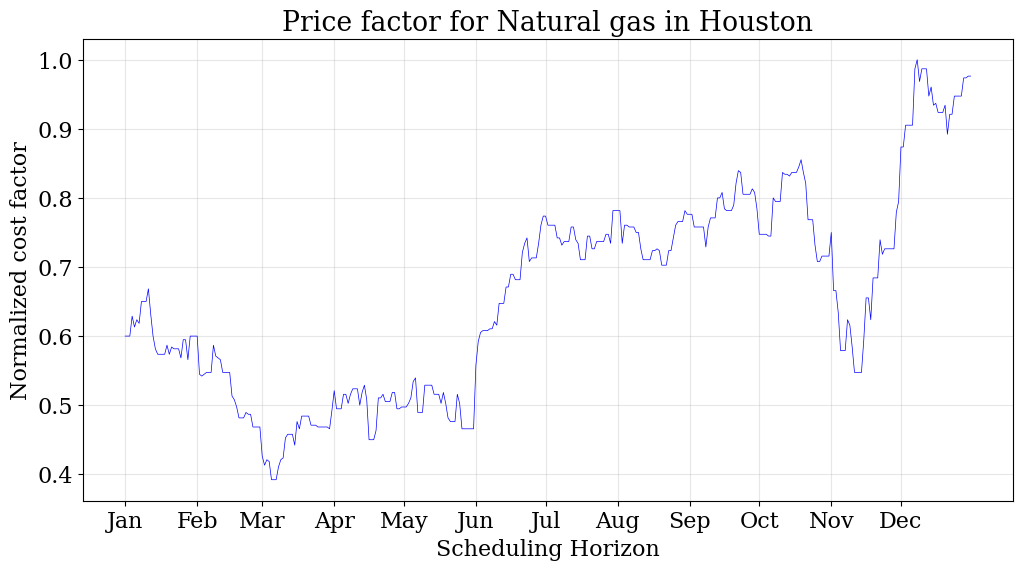

In [ ]:
# plot_location.capacity_factor(process=PV, location=ho)
# plot_location.capacity_factor(process=WF, location=ho)
plot_location.price_factor(resource=CH4, location=ho)

## Declare scenario 

In the base case all processes are considered and the demand is met annually.

In [19]:
scenario_bc = Scenario(name='scenario_bc', network=network, scales=scales, scheduling_scale_level=2,
                    network_scale_level=0, demand_scale_level=0, label='full case', demand= {at: {H2_sell: 3000}}, annualization_factor = 0.05)


NameError: name 'at' is not defined

## Formulate MILP model

In [ ]:
milp_bc = formulate(scenario = scenario_bc, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                      Constraints.RESOURCE_BALANCE, Constraints.DEMAND, Constraints.TRANSPORT}, objective= Objective.COST) 

min cost

s.t.

constraint process capex
constraint location capex
constraint network capex
constraint total capex
constraint process fopex
constraint location fopex
constraint network fopex
constraint total fopex
constraint process vopex
constraint location vopex
constraint network vopex
constraint total vopex
constraint resource purchase certain
constraint resource purchase varying
constraint location resource purchase
constraint network resource purchase
constraint total purchase
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport total capex
constraint transport total vopex
constraint transport total fopex
constraint total cost
constraint nameplate inventory
constraint storage max
constraint storage min
constraint production mode
constraint nameplate production certain capacity
constraint namep

In [21]:
results_bc = solve(scenario = scenario_bc, instance = milp_bc, solver= 'gurobi', name= 'results_bc', print_solversteps= True, saveformat='.pkl')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 446929 rows, 359353 columns and 1222108 nonzeros
Model fingerprint: 0x5d844093
Coefficient statistics:
  Matrix range     [4e-05, 9e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 1e+06]
Presolve removed 320181 rows and 267636 columns
Presolve time: 1.27s
Presolved: 126748 rows, 91717 columns, 415279 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.06s

Barrier statistics:
 Dense cols : 11
 AA' NZ     : 6.214e+05
 Factor NZ  : 2.043e+06 (roughly 100 MB of memory)
 Factor Ops : 3.542e+07 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal    

In [22]:
results_bc.output['P_location']

{('consumption', 'ASMR', 0): 0.0,
 ('consumption', 'AqOff', 0): 0.0,
 ('consumption', 'H2_Comp', 0): 0.0,
 ('consumption', 'H2_DComp', 0): 3000.0000000001432,
 ('consumption', 'LiI', 0): 0.0,
 ('consumption', 'LiI_discharge', 0): 0.0,
 ('consumption', 'NGCC', 0): 0.0,
 ('consumption', 'PEM', 0): 0.0,
 ('consumption', 'PV', 0): 0.0,
 ('consumption', 'SMRH', 0): 0.0,
 ('consumption', 'WF', 0): 0.0,
 ('generation', 'ASMR', 0): 9732.764206956585,
 ('generation', 'AqOff', 0): 0.0,
 ('generation', 'H2_Comp', 0): 3000.0000000001432,
 ('generation', 'H2_DComp', 0): 0.0,
 ('generation', 'LiI', 0): 0.0,
 ('generation', 'LiI_discharge', 0): 0.0,
 ('generation', 'NGCC', 0): 0.0,
 ('generation', 'PEM', 0): 8481.76420695427,
 ('generation', 'PV', 0): 0.0,
 ('generation', 'SMRH', 0): 0.0,
 ('generation', 'WF', 0): 0.0}

## Scenario analysis

We consider three distinct scenarios:

1. **green**: Meet an annual demand for green hydrogen [PV, WF, PEM, etc.]
2. **blue**: Meet an annual demand for blue hydrogen [PV, NGCC, AQoff, SMRH, etc.] 
4. **active**: Have an active supply chain with ships reaching Athens daily. Meet an equal demand for green hydrogen everyday [PV, WF, PEM, etc.]

In [23]:
def scenario_generator(scenario_name:str, process_set: set, demand: float, demand_scale: int) -> Scenario: 
    ho = Location(name='generation', processes= process_set, 
                                capacity_factor={PV: solar_houston_mean[:8760*horizon], WF: wind_houston_mean[:8760*horizon]}, price_factor={CH4: ng_price_df[:365*horizon]},
                                scales=scales, label='Houston', capacity_factor_scale_level=2, price_factor_scale_level=1)


    at = Location(name='consumption', processes= {H2_DComp}, scales=scales, label='Athens')

    ship = Transport(name= 'Ship', resources= {H2_C}, trans_max= bigM, trans_loss= 0.001, capex= 2*10**6, vopex = 0.01
        , label= 'Ship for transporting hydrogen')

    distance_matrix = [
        [6322] ]

    transport_matrix = [
        [[ship]] ]

    network = Network(name= 'Network', source_locations= [ho], 
                    sink_locations= [at], 
                    distance_matrix= distance_matrix, transport_matrix= transport_matrix, scales = scales) 

    scenario = Scenario(name= scenario_name, network=network, scales=scales, scheduling_scale_level=2,
                        network_scale_level=0, demand_scale_level=demand_scale, label='full case', demand= {at: {H2_sell: demand}}, annualization_factor = 0.05) 
    
    return scenario


In [24]:
scenario_green = scenario_generator(scenario_name = 'scenario_g', process_set = {PV, WF, LiI, PEM, H2_Comp}, demand = 3000,  demand_scale = 0)
scenario_blue = scenario_generator(scenario_name = 'scenario_b', process_set = {LiI, NGCC, SMRH, AqOff, H2_Comp}, demand = 3000, demand_scale = 0)
scenario_active = scenario_generator(scenario_name = 'scenario_a', process_set = {PV, WF, LiI, PEM, H2_Comp}, demand = 3000/365, demand_scale = 1)


In [25]:
casestudy = CaseStudy(name = 'casestudy', scenarios= [scenario_green, scenario_blue, scenario_active])

In [26]:
casestudy.formulate(constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                      Constraints.RESOURCE_BALANCE, Constraints.DEMAND, Constraints.TRANSPORT}, objective=Objective.COST) 

min cost

s.t.

constraint process capex
constraint location capex
constraint network capex
constraint total capex
constraint process fopex
constraint location fopex
constraint network fopex
constraint total fopex
constraint process vopex
constraint location vopex
constraint network vopex
constraint total vopex
constraint resource purchase certain
constraint resource purchase varying
constraint location resource purchase
constraint network resource purchase
constraint total purchase
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport total capex
constraint transport total vopex
constraint transport total fopex
constraint total cost
constraint nameplate inventory
constraint storage max
constraint storage min
constraint production mode
constraint nameplate production certain capacity
constraint namep

{'scenario_g': <pyomo.core.base.PyomoModel.ConcreteModel at 0x18aaf34bfb0>,
 'scenario_b': <pyomo.core.base.PyomoModel.ConcreteModel at 0x18add4bfec0>,
 'scenario_a': <pyomo.core.base.PyomoModel.ConcreteModel at 0x18aefc7a200>}

In [27]:
results = casestudy.solve(solver='gurobi', print_solversteps=True, saveformat = '.pkl')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 297957 rows, 236651 columns and 766470 nonzeros
Model fingerprint: 0xc65f1918
Coefficient statistics:
  Matrix range     [5e-05, 6e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 1e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 223770 rows and 188739 columns
Presolve time: 0.33s
Presolved: 74187 rows, 47912 columns, 196277 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 2.360e+05
 Factor NZ  : 9.607e+05 (roughly 60 MB of memory)
 Factor Ops : 1.411e+07 (less than 1 second p

In [28]:
scenario_bc.set_dict['resources_trans']

['H2(C)']

In [29]:
results_g = results.results['scenario_g']
results_b = results.results['scenario_b']
results_a = results.results['scenario_a']

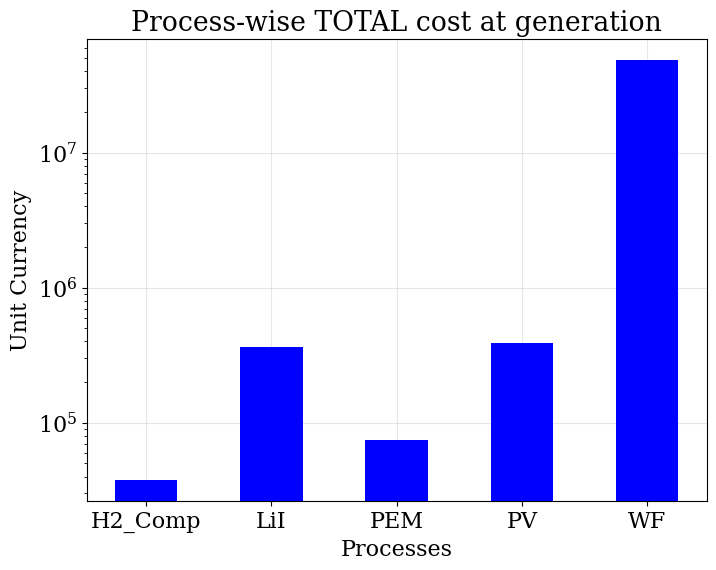

In [30]:
plot_results.cost(results= results_g, x = CostX.PROCESS_WISE, y = CostY.TOTAL, location= 'generation', fig_size= (8,6))


In [ ]:
results_g.

In [31]:

def make_cost_dicts(result_):
    cost_summary_dict = {'capex': result_.output['Capex_total'][None],
                            'fopex': result_.output['Fopex_total'][None],
                            'vopex': result_.output['Vopex_total'][None],
                            'cost_purch': result_.output['B_total'][None],
                            'transport_capex':  result_.output['Capex_transport_network'][0],
                            'transport_fopex':  result_.output['Fopex_transport_network'][0],
                            'transport_vopex': result_.output['Vopex_transport_network'][0],
                            'cost_total': result_.output['Cost_total'][None]}
                            # 'incidental': result_.output['Incidental_total'],
                            # 'storage_cost':,
                            # 'land_cost':,
                            # 'credit':,
    cost_contri_dict = {i: 100*j/cost_summary_dict['cost_total'] for i,j in cost_summary_dict.items()}
    return cost_summary_dict, cost_contri_dict

cs_bc, cc_bc = make_cost_dicts(results_bc)
cs_g, cc_g = make_cost_dicts(results.results['scenario_g'])
cs_b, cc_b = make_cost_dicts(results.results['scenario_b'])
cs_a, cc_a = make_cost_dicts(results.results['scenario_a'])

In [32]:
sum(cs_g.values())/sum(cs_b.values())

0.9653637162125616

In [33]:
(sum(cs_b.values()) - sum(cs_g.values()))/sum(cs_g.values())

0.03587899897805141

In [34]:
cs_b['cost_purch']/cs_b['cost_total']

0.013308682413918204

In [71]:
(cs_g['transport_capex'] + cs_g['transport_fopex'] + cs_g['transport_vopex'])/((cs_g['capex'] + cs_g['fopex'] + cs_g['vopex']) + (cs_g['transport_capex'] + cs_g['transport_fopex'] + cs_g['transport_vopex']))

0.8136051088961428

In [36]:
(cs_b['transport_capex'] + cs_b['transport_fopex'] + cs_b['transport_vopex'])

216696509.31506848

In [37]:
cs_a['cost_total']/cs_g['cost_total']

1.0000000000000016

In [38]:
results_b.output['Vopex_process']

{('consumption', 'AqOff', 0): 0.0,
 ('consumption', 'H2_Comp', 0): 0.0,
 ('consumption', 'H2_DComp', 0): 3.0000000000001465,
 ('consumption', 'LiI', 0): 0.0,
 ('consumption', 'LiI_discharge', 0): 0.0,
 ('consumption', 'NGCC', 0): 0.0,
 ('consumption', 'SMRH', 0): 0.0,
 ('generation', 'AqOff', 0): 21022844.38143145,
 ('generation', 'H2_Comp', 0): 10500.000000000513,
 ('generation', 'H2_DComp', 0): 0.0,
 ('generation', 'LiI', 0): 0.0,
 ('generation', 'LiI_discharge', 0): 0.0,
 ('generation', 'NGCC', 0): 32300290.407872766,
 ('generation', 'SMRH', 0): 154500.00000000806}

In [39]:
cc_b

{'capex': 0.44422410830456954,
 'fopex': 0.2954507009645812,
 'vopex': 19.38697976763465,
 'cost_purch': 1.3308682413918205,
 'transport_capex': 78.47373419055344,
 'transport_fopex': 0.0,
 'transport_vopex': 0.06874299115092818,
 'cost_total': 100.0}

In [40]:
results_g.output['Cap_P']

{('consumption', 'H2_Comp', 0): 0.0,
 ('consumption', 'H2_DComp', 0): 0.3424657534246575,
 ('consumption', 'LiI', 0): 0.0,
 ('consumption', 'LiI_discharge', 0): None,
 ('consumption', 'PEM', 0): 0.0,
 ('consumption', 'PV', 0): 0.0,
 ('consumption', 'WF', 0): 0.0,
 ('generation', 'H2_Comp', 0): 0.3424657534246575,
 ('generation', 'H2_DComp', 0): 0.0,
 ('generation', 'LiI', 0): 0.028956601492166553,
 ('generation', 'LiI_discharge', 0): 100.0,
 ('generation', 'PEM', 0): 0.9682379231683842,
 ('generation', 'PV', 0): 0.7418954139051034,
 ('generation', 'WF', 0): 7.697962557686231}

In [41]:
results_b.output['Cap_P']

{('consumption', 'AqOff', 0): 0.0,
 ('consumption', 'H2_Comp', 0): 0.0,
 ('consumption', 'H2_DComp', 0): 0.3424657534246575,
 ('consumption', 'LiI', 0): 0.0,
 ('consumption', 'LiI_discharge', 0): None,
 ('consumption', 'NGCC', 0): 0.0,
 ('consumption', 'SMRH', 0): 0.0,
 ('generation', 'AqOff', 0): 5.796782802107342,
 ('generation', 'H2_Comp', 0): 0.3424657534246575,
 ('generation', 'H2_DComp', 0): 0.0,
 ('generation', 'LiI', 0): 0.0,
 ('generation', 'LiI_discharge', 0): 100.0,
 ('generation', 'NGCC', 0): 9.21811940863908,
 ('generation', 'SMRH', 0): 0.3424657534246575}

In [42]:
results_a.output['Cap_P']

{('consumption', 'H2_Comp', 0): 0.0,
 ('consumption', 'H2_DComp', 0): 0.34246575342465757,
 ('consumption', 'LiI', 0): 0.0,
 ('consumption', 'LiI_discharge', 0): None,
 ('consumption', 'PEM', 0): 0.0,
 ('consumption', 'PV', 0): 0.0,
 ('consumption', 'WF', 0): 0.0,
 ('generation', 'H2_Comp', 0): 0.34246575342465757,
 ('generation', 'H2_DComp', 0): 0.0,
 ('generation', 'LiI', 0): 0.028956601492166556,
 ('generation', 'LiI_discharge', 0): 100.0,
 ('generation', 'PEM', 0): 0.9682379231683844,
 ('generation', 'PV', 0): 0.7418954139051036,
 ('generation', 'WF', 0): 7.697962557686232}

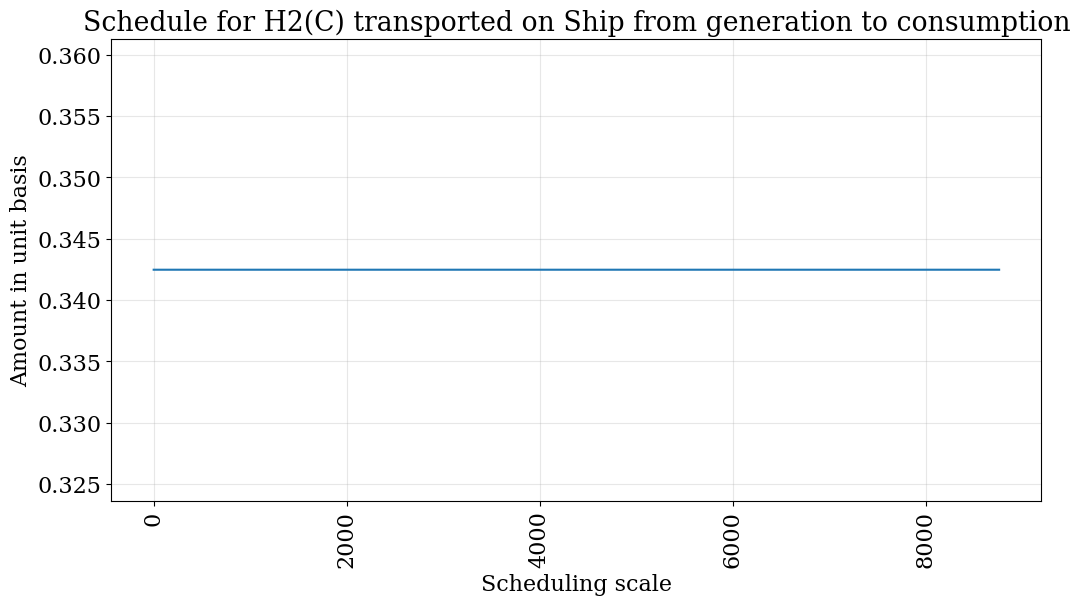

In [43]:
# plot_results.transport(results=results_bc, source='generation', sink='consumption', resource='H2(C)', transport='Ship')
plot_results.transport(results=results_a, source='generation', sink='consumption', resource='H2(C)', transport='Ship')


In [44]:
netcost_g = sum(cs_g[i] for i in ['capex', 'fopex', 'vopex', 'transport_capex', 'transport_fopex', 'transport_vopex'])

In [45]:
netcost_b = sum(cs_b[i] for i in ['capex', 'fopex', 'vopex', 'transport_capex', 'transport_fopex', 'transport_vopex'])

In [46]:
netcost_g/netcost_b

0.9783846286327174

In [47]:
results_bc.output['Capex_process']

{('consumption', 'ASMR', 0): 0.0,
 ('consumption', 'AqOff', 0): 0.0,
 ('consumption', 'H2_Comp', 0): 0.0,
 ('consumption', 'H2_DComp', 0): 1.7123287671232703e-05,
 ('consumption', 'LiI', 0): 0.0,
 ('consumption', 'LiI_discharge', 0): 0.0,
 ('consumption', 'NGCC', 0): 0.0,
 ('consumption', 'PEM', 0): 0.0,
 ('consumption', 'PV', 0): 0.0,
 ('consumption', 'SMRH', 0): 0.0,
 ('consumption', 'WF', 0): 0.0,
 ('generation', 'ASMR', 0): 443804.65949724277,
 ('generation', 'AqOff', 0): 0.0,
 ('generation', 'H2_Comp', 0): 27397.260273972322,
 ('generation', 'H2_DComp', 0): 0.0,
 ('generation', 'LiI', 0): 0.0,
 ('generation', 'LiI_discharge', 0): 0.0,
 ('generation', 'NGCC', 0): 0.0,
 ('generation', 'PEM', 0): 75038.439045549,
 ('generation', 'PV', 0): 0.0,
 ('generation', 'SMRH', 0): 0.0,
 ('generation', 'WF', 0): 0.0}

In [48]:
results.results['scenario_g'].output['Capex_process']

{('consumption', 'H2_Comp', 0): 0.0,
 ('consumption', 'H2_DComp', 0): 1.7123287671232875e-05,
 ('consumption', 'LiI', 0): 0.0,
 ('consumption', 'LiI_discharge', 0): 0.0,
 ('consumption', 'PEM', 0): 0.0,
 ('consumption', 'PV', 0): 0.0,
 ('consumption', 'WF', 0): 0.0,
 ('generation', 'H2_Comp', 0): 27397.260273972603,
 ('generation', 'H2_DComp', 0): 0.0,
 ('generation', 'LiI', 0): 1885.3382622136214,
 ('generation', 'LiI_discharge', 0): 0.0,
 ('generation', 'PEM', 0): 75038.43904554978,
 ('generation', 'PV', 0): 49457.0481666973,
 ('generation', 'WF', 0): 562721.0629668635}

In [49]:
cs_g

{'capex': 716499.14873242,
 'fopex': 348996.01984230656,
 'vopex': 48579131.95424259,
 'cost_purch': 27.005089058525062,
 'transport_capex': 216506849.31506848,
 'transport_fopex': 0.0,
 'transport_vopex': 189660.00000000926,
 'cost_total': 266341163.44297484}

In [50]:
cc_g

{'capex': 0.2690155511338474,
 'fopex': 0.13103345173192824,
 'vopex': 18.23943821760907,
 'cost_purch': 1.0139284784008615e-05,
 'transport_capex': 81.2892932193802,
 'transport_fopex': 0.0,
 'transport_vopex': 0.07120942086018053,
 'cost_total': 100.0}

In [51]:
results_bc.output['Cap_P']

{('consumption', 'ASMR', 0): 0.0,
 ('consumption', 'AqOff', 0): 0.0,
 ('consumption', 'H2_Comp', 0): 0.0,
 ('consumption', 'H2_DComp', 0): 0.342465753424654,
 ('consumption', 'LiI', 0): 0.0,
 ('consumption', 'LiI_discharge', 0): None,
 ('consumption', 'NGCC', 0): 0.0,
 ('consumption', 'PEM', 0): 0.0,
 ('consumption', 'PV', 0): 0.0,
 ('consumption', 'SMRH', 0): 0.0,
 ('consumption', 'WF', 0): 0.0,
 ('generation', 'ASMR', 0): 1.111046142346455,
 ('generation', 'AqOff', 0): 0.0,
 ('generation', 'H2_Comp', 0): 0.342465753424654,
 ('generation', 'H2_DComp', 0): 0.0,
 ('generation', 'LiI', 0): 0.0,
 ('generation', 'LiI_discharge', 0): 100.0,
 ('generation', 'NGCC', 0): 0.0,
 ('generation', 'PEM', 0): 0.9682379231683743,
 ('generation', 'PV', 0): 0.0,
 ('generation', 'SMRH', 0): 0.0,
 ('generation', 'WF', 0): 0.0}

In [52]:
results.results['scenario_g'].output['Cap_P']

{('consumption', 'H2_Comp', 0): 0.0,
 ('consumption', 'H2_DComp', 0): 0.3424657534246575,
 ('consumption', 'LiI', 0): 0.0,
 ('consumption', 'LiI_discharge', 0): None,
 ('consumption', 'PEM', 0): 0.0,
 ('consumption', 'PV', 0): 0.0,
 ('consumption', 'WF', 0): 0.0,
 ('generation', 'H2_Comp', 0): 0.3424657534246575,
 ('generation', 'H2_DComp', 0): 0.0,
 ('generation', 'LiI', 0): 0.028956601492166553,
 ('generation', 'LiI_discharge', 0): 100.0,
 ('generation', 'PEM', 0): 0.9682379231683842,
 ('generation', 'PV', 0): 0.7418954139051034,
 ('generation', 'WF', 0): 7.697962557686231}

In [53]:
results.results['scenario_b'].output['Cap_P']

{('consumption', 'AqOff', 0): 0.0,
 ('consumption', 'H2_Comp', 0): 0.0,
 ('consumption', 'H2_DComp', 0): 0.3424657534246575,
 ('consumption', 'LiI', 0): 0.0,
 ('consumption', 'LiI_discharge', 0): None,
 ('consumption', 'NGCC', 0): 0.0,
 ('consumption', 'SMRH', 0): 0.0,
 ('generation', 'AqOff', 0): 5.796782802107342,
 ('generation', 'H2_Comp', 0): 0.3424657534246575,
 ('generation', 'H2_DComp', 0): 0.0,
 ('generation', 'LiI', 0): 0.0,
 ('generation', 'LiI_discharge', 0): 100.0,
 ('generation', 'NGCC', 0): 9.21811940863908,
 ('generation', 'SMRH', 0): 0.3424657534246575}

In [54]:
results.results['scenario_a'].output['Cap_P']

{('consumption', 'H2_Comp', 0): 0.0,
 ('consumption', 'H2_DComp', 0): 0.34246575342465757,
 ('consumption', 'LiI', 0): 0.0,
 ('consumption', 'LiI_discharge', 0): None,
 ('consumption', 'PEM', 0): 0.0,
 ('consumption', 'PV', 0): 0.0,
 ('consumption', 'WF', 0): 0.0,
 ('generation', 'H2_Comp', 0): 0.34246575342465757,
 ('generation', 'H2_DComp', 0): 0.0,
 ('generation', 'LiI', 0): 0.028956601492166556,
 ('generation', 'LiI_discharge', 0): 100.0,
 ('generation', 'PEM', 0): 0.9682379231683844,
 ('generation', 'PV', 0): 0.7418954139051036,
 ('generation', 'WF', 0): 7.697962557686232}

In [55]:
from pyomo.environ import Objective
model_obj = [i for i in milp_bc.component_objects()
                if i.ctype == Objective]

In [56]:
results_bc.output['S_network']

{('CO2_AQoff', 0): 0.0,
 ('CO2_Vent', 0): 0.0,
 ('H2(Sell)', 0): 3000.0000000001432,
 ('O2', 0): 24005.089058520178}

In [57]:
results.results['scenario_g'].output['S_network']

{('H2(Sell)', 0): 3000.0000000001464, ('O2', 0): 24005.089058520207}

In [58]:
results.results['scenario_b'].output['S_network']

{('CO2_AQoff', 0): 48240.82647913276,
 ('CO2_Vent', 0): 4289.148281392056,
 ('H2(Sell)', 0): 3000.0000000001464}

In [59]:
results_bc.output['Capex_network']

{0: 546240.3588338874}

In [60]:
results.results['scenario_g'].output['Capex_network']

{0: 716499.14873242}

In [61]:
results_bc.output['objective']

962970.1253398622

In [62]:
results.results['scenario_g'].output['objective']

266341163.44297484

In [63]:
results.results['scenario_a'].output['objective']

266341163.44297522

In [64]:
results.results['scenario_a'].output['S_network']

{('H2(Sell)', 0): 3000.0000000001464, ('O2', 0): 24005.089058520207}

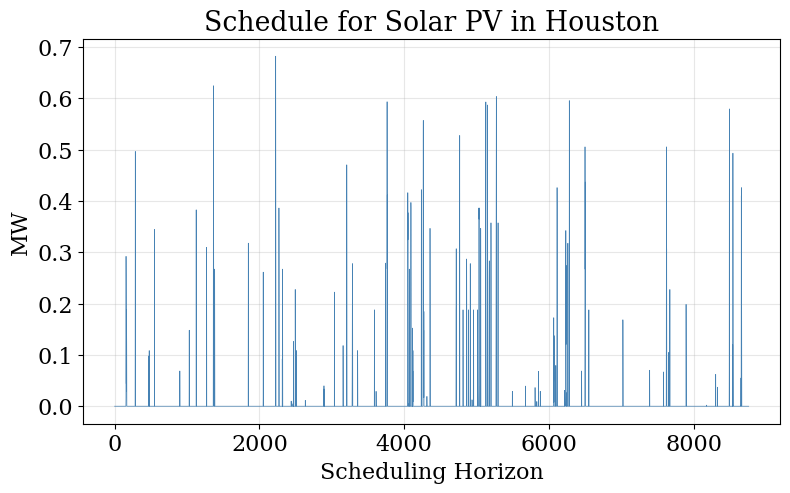

In [70]:
plot_results.schedule(results=results.results['scenario_g'], y_axis='P', component='PV',
                      location='generation', fig_size=(9, 5), color='steelblue')

In [66]:
plot_results.schedule(results=results.results['scenario'], y_axis='Inv', component='LiI_Power_stored',
                      location='generation', fig_size=(9, 5), color='steelblue')

KeyError: 'scenario'

In [ ]:
plot_results.schedule(results=results.results['scenario_g'], y_axis='S', component='H2(Sell)',
                      location='consumption', fig_size=(9, 5), color='steelblue')

In [ ]:
plot_results.schedule(results=results.results['scenario_a'], y_axis='S', component='H2(Sell)',
                      location='consumption', fig_size=(9, 5), color='steelblue')

In [ ]:
plot_results.schedule(results=results.results['scenario'], y_axis='P', component='PEM',
                      location='generation', fig_size=(9, 5), color='steelblue')

In [ ]:
results.results['scenario'].output['objective']

In [ ]:
results.results['scenario'].divide_objective_by('S_network',('H2(Sell)', 0))

In [ ]:
plot_results.cost(results=results.results['scenario_mean'], x=CostX.PROCESS_WISE,
                  y=CostY.TOTAL, location='generation', fig_size=(12, 6))

In [ ]:
plot_results.cost(results=results.results['scenario_mean'], x=CostX.PROCESS_WISE,
                  y=CostY.TOTAL, location='sequestration', fig_size=(12, 6))

In [ ]:
plot_results.cost(results=results.results['scenario_mean'], x=CostX.PROCESS_WISE,
                  y=CostY.TOTAL, location='production', fig_size=(12, 6))

In [ ]:
plot_results.schedule(results=results.results['scenario_mean'], y_axis='P', component='PEM',
                      location='production', fig_size=(9, 5), color='steelblue')

In [ ]:
plot_results.schedule(results=results.results['scenario_mean'], y_axis='S', component='H2(C)',
                      location='consumption', fig_size=(9, 5), color='steelblue')

In [ ]:
plot_results.schedule(results=results.results['scenario_mean'], y_axis='Inv', component='LiI_Power_stored',
                      location='generation', fig_size=(9, 5), color='steelblue')

In [ ]:
# x = results_dict.results['scenario_max'].output['Inv'].values()
# x2 = results_dict.results['scenario_mean'].output['Inv'].values()


In [ ]:
plot_results.schedule(results=results.results['scenario_mean'], y_axis='P', component='PV',
                      location='generation', fig_size=(9, 5), color='steelblue')

In [ ]:
plot_results.schedule(results=results.results['scenario_mean'], y_axis='P', component='WF',
                      location='generation', fig_size=(9, 5), color='steelblue')

In [ ]:
PV_plot = [results.results['scenario_mean'].output['P'][('generation', 'PV', *i)] for i in product(range(horizon), range(365), range(24))][:24*7]
WF_plot = [results.results['scenario_mean'].output['P'][('generation', 'WF', *i)] for i in product(range(horizon), range(365), range(24))][:24*7]
LiI_plot = [results.results['scenario_mean'].output['Inv'][('generation', 'LiI_Power_stored', *i)] for i in product(range(horizon), range(365), range(24))][:24*7]
# LiI_plot = [results.results['scenario_mean'].output['P'][('generation', 'LiI', *i)] for i in product(range(horizon), range(365), range(24))][:24*7]


In [ ]:

rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize=(9,6))
ax2 = ax.twinx()
x_ = list(range(len(PV_plot)))
ax.plot(x_, PV_plot, label = 'PV', color = 'orange')
ax.plot(x_, WF_plot, label = 'WF', color = 'blue')
ax2.plot(x_, LiI_plot, label = 'LiI', color = 'green', linestyle = '--')

# ax = axis_formatter(axes=ax, xcord=x_, axis_labels='M')
plt.title('Power production and energy storage levels')
ax.set_ylabel("Production rate (MW)")
ax2.set_ylabel("Inventory Level (MJ)")
ax2.yaxis.label.set_color('green')
ax2.set_xlabel("Scheduling Horizon (1st week)")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# ax2.set_legend()
plt.grid(alpha=0.3)
plt.rcdefaults()

In [ ]:
values = [(i,j) for i,j in results.results['scenario_mean'].output['Capex_process'].items() if j>0]
x = [i[0][1] for i in values]
y = [i[1] for i in values]

In [ ]:
y

In [ ]:
x

In [ ]:
plt.bar(x,y)

In [ ]:
plot_results.transport(results=results.results['scenario_mean'], source='generation', sink='production', resource='Power', transport='Grid')
plot_results.transport(results=results.results['scenario_mean'], source='generation', sink='sequestration', resource='CO2', transport='carbon')


In [ ]:
plot_results.schedule(results=results.results['scenario_mean'], y_axis='P', component='AqOff',
                      location='sequestration', fig_size=(9, 5), color='steelblue')